# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from skimage import exposure
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

# Loading Dataset

In [2]:
# Load MNIST dataset (70,000 images of 28x28 handwritten digits)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

print("Dataset shape:", X.shape)
print("Labels:", np.unique(y))

Dataset shape: (70000, 784)
Labels: [0 1 2 3 4 5 6 7 8 9]


# Splitting data for Train and Test

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)


# Computing HOG

In [4]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        image_2d = img.reshape((28, 28))
        features = hog(image_2d,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       block_norm='L2-Hys',
                       visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

# Extract features
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)


# SVM Training

In [5]:
model = LinearSVC(max_iter=10000, random_state=42)
model.fit(X_train_hog, y_train)

LinearSVC(max_iter=10000, random_state=42)

# Evaluation

Accuracy: 0.9425

Classification Report:
              precision    recall  f1-score   support

           0     0.9629    0.9780    0.9704      1726
           1     0.9740    0.9721    0.9731      1969
           2     0.9437    0.9394    0.9415      1748
           3     0.9413    0.9255    0.9333      1785
           4     0.9279    0.9285    0.9282      1706
           5     0.9559    0.9468    0.9513      1578
           6     0.9587    0.9727    0.9656      1719
           7     0.9171    0.9227    0.9199      1823
           8     0.9152    0.9238    0.9195      1706
           9     0.9255    0.9132    0.9193      1740

    accuracy                         0.9425     17500
   macro avg     0.9422    0.9422    0.9422     17500
weighted avg     0.9424    0.9425    0.9424     17500

ROC-AUC (macro-average): 0.9679
ROC-AUC (micro-average): 0.9680


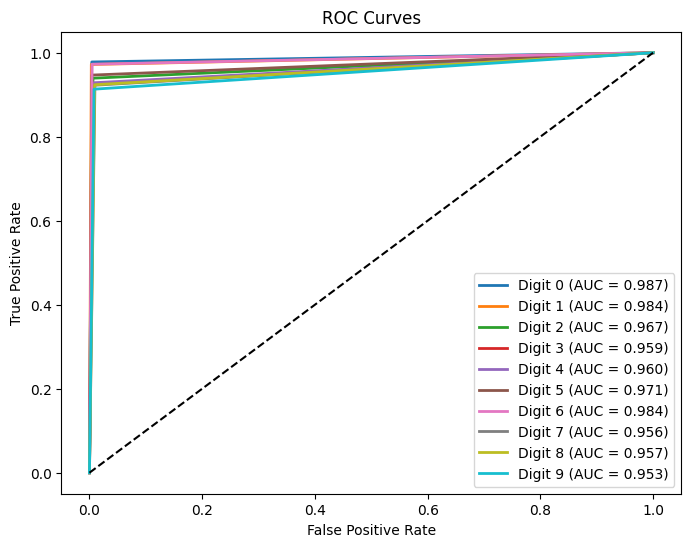

In [6]:
y_pred = model.predict(X_test_hog)

# ✅ 1. Basic Metrics
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")

# ✅ 2. Precision, Recall, F1 (for each class + averages)
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ✅ 3. ROC & AUC (One-vs-Rest)
# Convert y_test and y_pred to one-hot (binarize) for ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = label_binarize(y_pred, classes=classes)

roc_auc_macro = roc_auc_score(y_test_bin, y_score, average='macro')
roc_auc_micro = roc_auc_score(y_test_bin, y_score, average='micro')

print(f"ROC-AUC (macro-average): {roc_auc_macro:.4f}")
print(f"ROC-AUC (micro-average): {roc_auc_micro:.4f}")

# ✅ 4. Optional: Plot ROC Curves
plt.figure(figsize=(8,6))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Digit {i} (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# Confusion Matrix

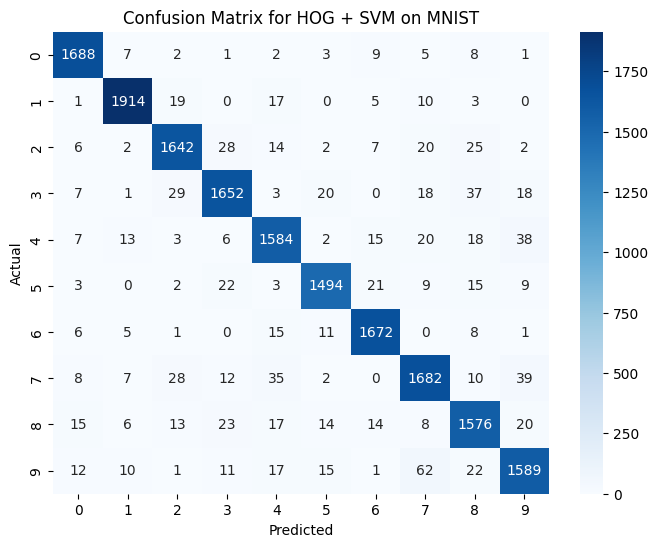

In [7]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for HOG + SVM on MNIST')
plt.show()

# Visualizing HOG images

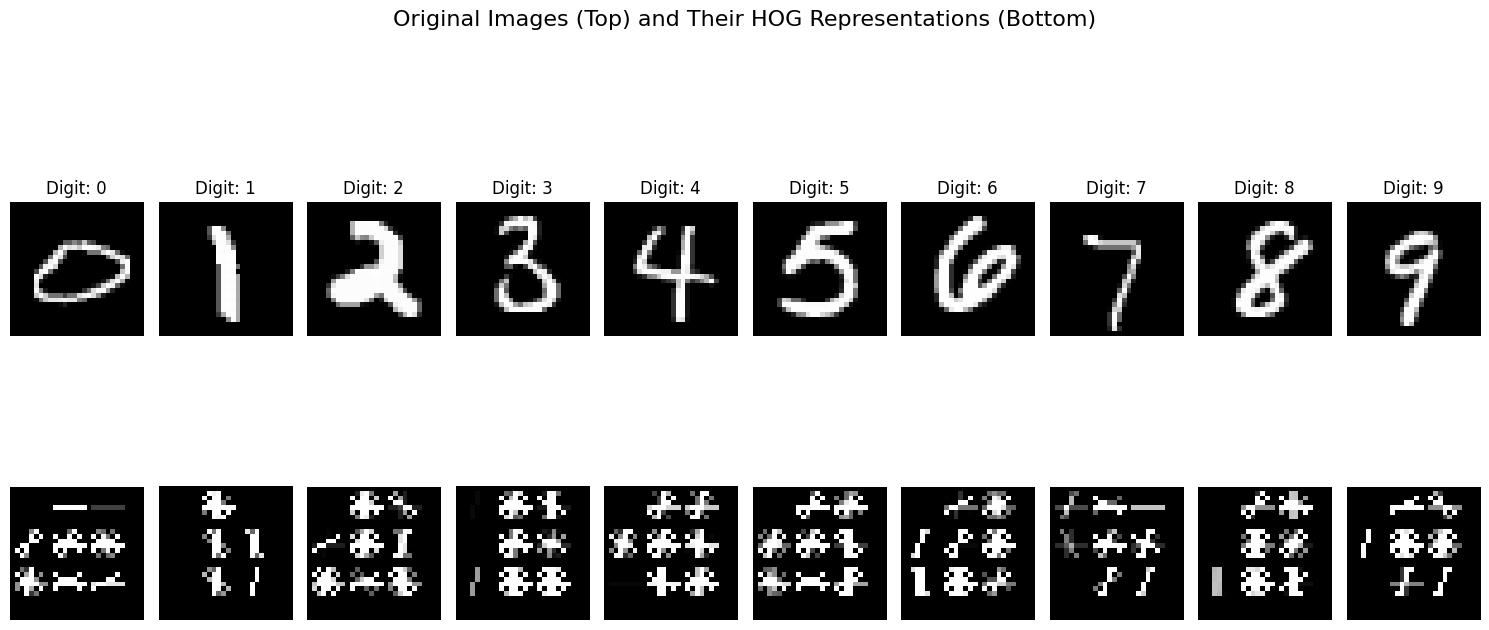

In [8]:
# Pick one sample per label (0–9)
samples = []
for digit in range(10):
    idx = np.where(y_train == digit)[0][0]  # first occurrence of that digit
    samples.append(X_train[idx])

# Create the visualization grid
plt.figure(figsize=(15, 8))
for i, sample in enumerate(samples):
    image = sample.reshape((28, 28))

    # Extract HOG features and visualization
    fd, hog_image = hog(image,
                        orientations=9,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        block_norm='L2-Hys',
                        visualize=True)

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Show Original and HOG side by side
    plt.subplot(2, 10, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Digit: {i}")
    plt.axis('off')

    plt.subplot(2, 10, i + 11)
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.axis('off')

plt.suptitle("Original Images (Top) and Their HOG Representations (Bottom)", fontsize=16)
plt.tight_layout()
plt.show()